### i. Initialize project

In [69]:
import pandas as pd
import numpy as np        
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from sklearn.model_selection import cross_validate, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, make_scorer, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.decomposition import PCA


from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

#import file
banks_df = pd.read_csv('../data/bank-additional/bank-additional-full.csv', sep=';')


### ii. Preprocess Data

In [10]:
# prep data for pipeline
df = banks_df.copy()
df = df.drop(["day_of_week", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m","nr.employed","duration", "housing"], axis=1)

# Bin education to save dimensions
df["education"] = df["education"].map({
    "basic.4y": "primary",
    "basic.6y": "primary",
    "basic.9y": "secondary",
    "high.school": "secondary",
    "university.degree": "tertiary",
    "professional.course": "other",
    "unknown": "other",
    "illiterate": "other"
})
df['job'] = df['job'].replace('admin.', 'admin')

# Make varible for prior contact status
# set pdays null values to NAs
df['pdays'] = df['pdays'].replace(999, np.nan) 
# transform pdays to bins, since range 0-27, use 3 bins
df['pdays'] = pd.qcut(df['pdays'], q=3, labels=[1,2,3])

df['pdays'] = df['pdays'].cat.add_categories([-1])
df['pdays'] = df['pdays'].fillna(-1)


# split categorical and numerical features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'y']
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove('y')

# enforce that object types are treated as categorical
for col in categorical_cols:
    df[col] = df[col].astype('category')

   

In [ ]:
#split our data
X = df.drop(['y'], axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify=y)

In [ ]:
preprocessor =ColumnTransformer(
    transformers=[
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]), numeric_cols)
    ])

### 1.0 Building Baseline SVM Model

In [139]:
# Init pipeline: Preprocessing -> SMOTE -> SVM with random tuning params 
svm0_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=13)), 
    ('svm', SVC(kernel='rbf', C=.1, gamma='scale', probability=True))
])

# Train our model
svm0_pipe.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
# Helpers: use pipeline to preprocess X df and set to new df
# X_preprocessed = svm0_pipe.named_steps['preprocessor'].transform(X_train)
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# use pipeline to balance data and return new dfs
X_resampled, y_resampled = svm0_pipe.named_steps['smote'].fit_resample(X_train_preprocessed, y_train)


#### 1.0a Visualing Data with PCA

To get a sense of which kernel to use in our model, let's use PCA to visualize our data in 2 dimensions.

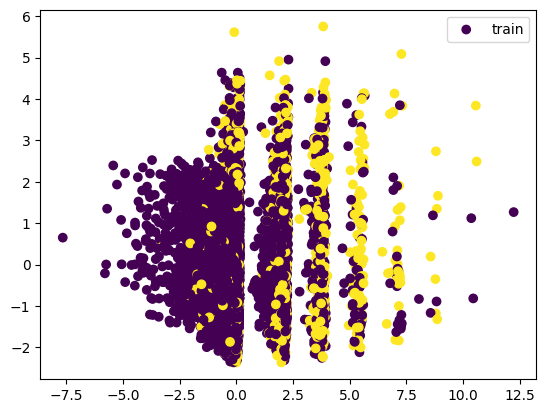

In [ ]:
# Use PCA to visualize in 2 dimensions
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_preprocessed) 

# now plot
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train.map({'no': 0, 'yes': 1}), label='train')
plt.legend()
plt.show()



#### 1.0b Visualize data with t-SNE

The PCA plot above shows clear banding as a result of using one-hot encoded categorical variables instead of numerical variables. t-SNE can use a mix of categorical and numerical in order to continue to use our pipeline for preprocessing. 

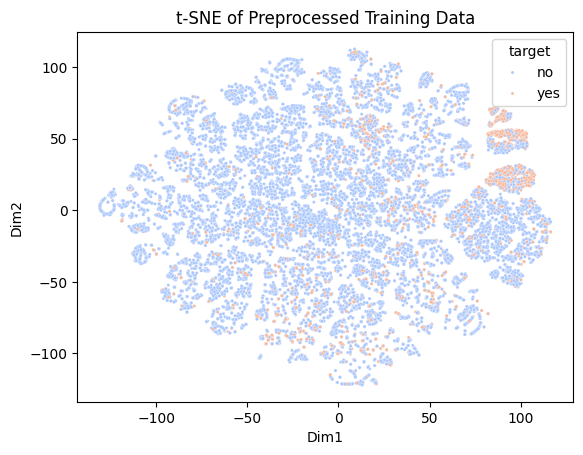

In [ ]:
# Use t-SNE to visualize data in 2 dimensions
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, random_state=13, perplexity=30).fit_transform(X_train_preprocessed)
tsne_df = pd.DataFrame(X_tsne, columns=['Dim1','Dim2'])
tsne_df['target'] = y_train.values

# now plot
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='target', palette='coolwarm', s=5)
plt.title("t-SNE of Preprocessed Training Data")
plt.show()


t-SNE visualization shows non-linear overlapping cloud suggesting RBF may be better kernel fit.

### 1.1 Hyperparameter Tuning

We will use Cross-Validation to test different tuning parameters: kernels (rbf/linear), cost penalties C (0.1, 1, 10) and gammas (scale, 0.1, 0.01).

In [ ]:
# use cross validation to tune

kernels = ['rbf', 'linear']
Cs = [0.1, 1, 10]
gammas = ['scale', 0.1, 0.01]

results = []
f1_yes = make_scorer(f1_score, pos_label='yes')

# test our tuning parameters
for test_kernel, test_C, test_gamma in product(kernels, Cs, gammas):

    pipe = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=13)), 
        ('svm', SVC(kernel=test_kernel, C=test_C, gamma=test_gamma))
    ])

    # get accuracy and f1 score using 5-fold CV
    scores = cross_validate(
        pipe,
        X_train, y_train,
        cv=5,
        scoring={'accuracy': 'accuracy', 'recall_yes': make_scorer(recall_score, pos_label='yes'), 'f1_yes': f1_yes },
        n_jobs=-1
    )

    results.append({
        'kernel': test_kernel,
        'C': test_C,
        'gamma': test_gamma,
        'accuracy': scores['test_accuracy'].mean(),
        'recall_yes': scores['test_recall_yes'].mean(),
        'f1_mean': scores['test_f1_yes'].mean()
    })
    print(f"kernel={test_kernel}, C={test_C}, gamma={test_gamma} → mean F1={scores['test_f1_yes'].mean():.3f}")



In [101]:
print(pd.DataFrame(results))

    kernel     C  gamma  accuracy  recall_yes   f1_mean
0      rbf   0.1  scale  0.823523    0.555415  0.415469
1      rbf   0.1    0.1  0.819569    0.557877  0.411137
2      rbf   0.1   0.01  0.782248    0.579734  0.375236
3      rbf   1.0  scale  0.829593    0.499683  0.398122
4      rbf   1.0    0.1  0.829142    0.495066  0.395357
5      rbf   1.0   0.01  0.837154    0.522773  0.419903
6      rbf  10.0  scale  0.846138    0.393160  0.365403
7      rbf  10.0    0.1  0.842912    0.388236  0.357753
8      rbf  10.0   0.01  0.852381    0.500918  0.434025
9   linear   0.1  scale  0.836149    0.481837  0.398806
10  linear   0.1    0.1  0.836149    0.481837  0.398806
11  linear   0.1   0.01  0.836149    0.481837  0.398806
12  linear   1.0  scale  0.837155    0.478142  0.398362
13  linear   1.0    0.1  0.837155    0.478142  0.398362
14  linear   1.0   0.01  0.837155    0.478142  0.398362
15  linear  10.0  scale  0.837155    0.477527  0.398062
16  linear  10.0    0.1  0.837155    0.477527  0

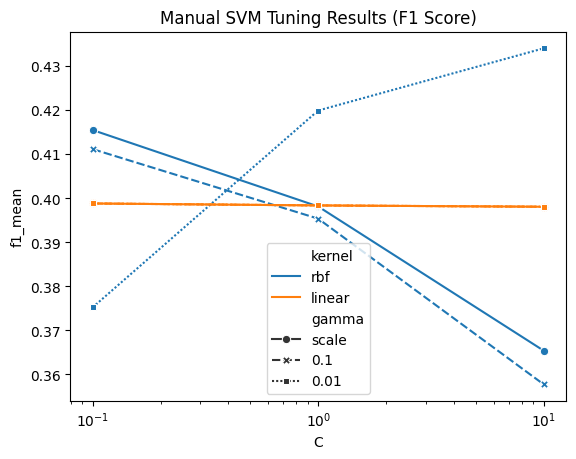

In [132]:
# show f1 chart
results_df = pd.DataFrame(results)

sns.lineplot(data=results_df, x='C', y='f1_mean', hue='kernel', style='gamma', markers=True)
plt.xscale('log')
plt.title('Manual SVM Tuning Results (F1 Score)')
plt.show()

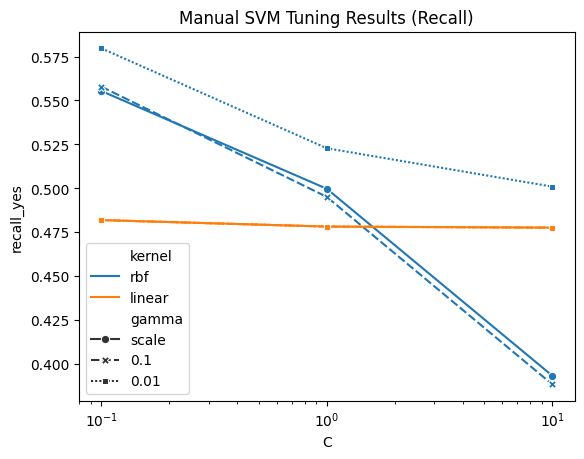

In [133]:
# show recal chart
sns.lineplot(data=results_df, x='C', y='recall_yes', hue='kernel', style='gamma', markers=True)
plt.xscale('log')
plt.title('Manual SVM Tuning Results (Recall)')
plt.show()

k-fold CV tests for kernel, gamma, and cost (C) confirm that RBF is a better fit on recall and perform better than linear model with a gamma of 0.01. However, all models yield relatively weak F1 Scores, maybe due to noise from SMOTE and/or to one-hot encoding. This test shows the model with the highest F1 score used an RBF kernel, C=10 and gamma=0.01 (model svm2_pipe). Our baseline model (svm1_pipe) conincidentally had the highest Recall value (0.579734) and used an RBF kernel, C=0.1 with a gamma=0.01.

Next, we will try to do perfom feature selection based on important features to see if we get better results.

In [ ]:
# Best Recall model

svm1_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=13)), 
    ('svm', SVC(kernel='rbf', C=0.1, gamma=0.01, probability=True))
])

# Train our model
svm1_pipe.fit(X_train, y_train)


# Best F1 model

svm2_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=13)), 
    ('svm', SVC(kernel='rbf', C=10, gamma=0.01, probability=True))
])

# Train our model
svm2_pipe.fit(X_train, y_train)

In [ ]:
#### 1.3 Refining Feature Selection

In [ ]:
# get import features
from sklearn.inspection import permutation_importance

X_test_transformed = svm1_pipe.named_steps['preprocessor'].transform(X_test)
feature_names = svm1_pipe.named_steps['preprocessor'].get_feature_names_out()

pi_result = permutation_importance(
    svm1_pipe.named_steps['svm'],   
    X_test_transformed,
    y_test,
    scoring=f1_yes,
    n_repeats=5,
    random_state=13
)

In [138]:
# print important features
importances = pd.DataFrame({
    'features': feature_names,
    'importance_mean': pi_result.importances_mean,
    'importance_std': pi_result.importances_std
}).sort_values('importance_mean', ascending=False)
importances.reset_index(drop=True, inplace=True)


print(importances.head(15))

                  features  importance_mean  importance_std
0           cat__month_aug         0.074786        0.002246
1           cat__month_jul         0.070268        0.002259
2            num__previous         0.063287        0.004263
3           cat__month_nov         0.062547        0.001715
4           cat__month_may         0.046021        0.005630
5    cat__poutcome_failure         0.016777        0.000505
6            num__campaign         0.011036        0.004322
7                 num__age         0.007648        0.002275
8    cat__contact_cellular         0.007044        0.001660
9   cat__contact_telephone         0.007044        0.001660
10          cat__month_oct         0.005761        0.000722
11          cat__month_jun         0.005678        0.000764
12          cat__month_apr         0.004622        0.001178
13           cat__pdays_-1         0.004272        0.000553
14          cat__month_mar         0.003483        0.000667


Create new model from most important features

In [ ]:
# new model 
top_features = importances.query('importance_mean > 0.005')['feature']
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

svm1_best_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=13)), 
    ('svm', SVC(kernel='rbf', C=10, gamma=0.01, probability=True))
])
svm1_best_pipe.fit(X_train_top, y_train)

In [ ]:
# use most important features to tune model
top_features = importances.query('importance_mean > 0.005')['feature']
X_train_top = X_train[top_features]

# use cross-validation to check if there are performace increases 
kernels = ['rbf']
Cs = [0.1, 1, 10]
gammas = ['scale', 0.1, 0.01]

results = []
f1_yes = make_scorer(f1_score, pos_label='yes')

# test our tuning parameters
for test_kernel, test_C, test_gamma in product(kernels, Cs, gammas):

    pipe = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=13)), 
        ('svm', SVC(kernel=test_kernel, C=test_C, gamma=test_gamma))
    ])

    # get accuracy and f1 score using 5-fold CV
    scores = cross_validate(
        pipe,
        X_train_top, y_train,
        cv=5,
        scoring={'accuracy': 'accuracy', 'f1_yes': f1_yes},
        n_jobs=-1
    )

    
    results.append({
        'kernel': test_kernel,
        'C': test_C,
        'gamma': test_gamma,
        'accuracy': scores['test_accuracy'].mean(),
        'f1_mean': scores['test_f1_yes'].mean()
    })
    print(f"kernel={test_kernel}, C={test_C}, gamma={test_gamma} → mean F1={scores['test_f1_yes'].mean():.3f}")

print(pd.DataFrame(results))

### 2. Model Comparison

In [81]:
# Import models from Assignment 2 
import joblib

# disqualify dt0 because likely overfitted
# disqualify dt3 because underperfoms after pruning
# best
dt1 = joblib.load('../models/bank_dt1.pkl')

# disqualify rf0 because of possible data leakage from not using pipeline
# best
rf2_pipe = joblib.load('../models/bank_rf2.pkl')

# best
ada3_pipe = joblib.load('../models/bank_ada3_pipe.pkl')

Show AUROC AUPRC for 'best' models. 

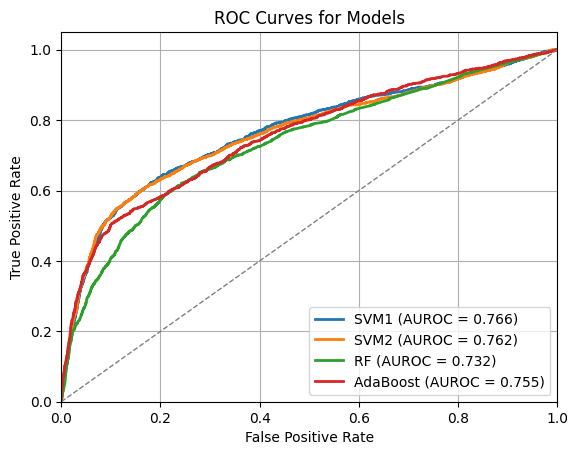

             AUROC
SVM1      0.765949
SVM2      0.762381
AdaBoost  0.754521
RF        0.732431


In [98]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

#'DT': dt1,
models = {'SVM1': svm1_pipe, 'SVM2': svm2_pipe,  'RF': rf2_pipe, 'AdaBoost': ada3_pipe}
auroc_results = {}
y_true = y_test.map({'no': 0, 'yes': 1})


for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1] 
    elif hasattr(model, "decision_function"): 
        y_scores = model.decision_function(X_test)
    else:
        print(f"{name} cannot compute AUROC")
        continue

    auroc_results[name] = roc_auc_score(y_true, y_scores)

    # Compute ROC curve and AUROC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUROC = {roc_auc:.3f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Convert to DataFrame
df_auroc = pd.DataFrame.from_dict(auroc_results, orient='index', columns=['AUROC']).sort_values(by='AUROC', ascending=False)
print(df_auroc)